In [23]:
# !pip install --index-url https://test.pypi.org/simple/ --no-deps lmpylib-mingsqtt

Looking in indexes: https://test.pypi.org/simple/


In [266]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import date
from datetime import datetime
from datetime import timedelta
import pytz
from lmpylib.core import *

In [2]:
os.chdir("d:/projects/pg-philippines")

In [474]:
raw_data = pd.read_csv("data/pg_data.csv")

In [475]:
common_cols = ['PO# (1st leg)', 'PO# (last leg)', 'Movement Type', 'Export Country', 'Import Country', 'Product Category', 'Ship Mode', 'Origin Port', 'Destination Port', 'Container Size / Type', 'Carrier', 'Vessel Name', 'Container Number', 'ETD', 'Latest ETD', 'ETA', 'Latest ETA', "ATD", "ATA"]
export_cols = ['Export Request Date', 'Carrier Booking Confirmation Date', 'Container Pick-up Date', 'Container Actual Arrival Date', 'Container Actual Arrival Time', 'Container Loading Date', 'Container Port Gate-In Date']
import_cols = ['Container Port Gate-out Date', 'Actual Delivery Date\n(1st Point of Delivery)', 'Empty Container Availability Date', 'Plant/DC Exit Date', 'Container return date', 'Latest Gate-Out (Port Storage)']

raw_data = raw_data[common_cols + import_cols + export_cols]

common_cols = ['po_1', 'po_2', 'movement', 'export_country', 'import_country', 'prod_cat', 'mode', 'ori_port', 'dest_port', 'size', 'carrier', 'vessel', 'container_no', 'etd', 'latest_etd', 'eta', 'latest_eta', "atd", "ata"]
export_cols = ['request_date', 'confirm_date', 'pickup_date', 'empty_arrival_date', 'arrival_time', 'loading_date', 'gatein_date']
import_cols = ['gateout_date', 'delivery_arrival_date', 'unload_finish_date', 'exit_date', 'returned_date', 'port_store_gateout_date']

raw_data.columns = common_cols + import_cols + export_cols

raw_data.to_csv("data/pg_data_reduced.csv", index=False)

In [476]:
raw_data = pd.read_csv("data/pg_data_reduced.csv")

for col in common_cols + import_cols + export_cols:
    raw_data.loc[(raw_data[col] == "N/A") | (raw_data[col] == "TBA"), col] = None

In [477]:
for col in ['etd', 'latest_etd', 'eta', 'latest_eta', "atd", "ata", 'request_date', 'confirm_date', 'pickup_date', 'empty_arrival_date', 'loading_date', 'gatein_date', 'gateout_date', 'delivery_arrival_date', 'unload_finish_date', 'exit_date', 'returned_date', 'port_store_gateout_date']:
    raw_data.loc[(raw_data[col] == "Export") | (raw_data[col] == "00-Jan-00"), col] = None
    ser = raw_data.loc[pd.isna(raw_data[col]) == False, col]
    ser = ser.apply(lambda s: datetime.strptime(s,"%d-%b-%y"))
    raw_data.loc[pd.isna(raw_data[col]) == False, col] = ser
    raw_data[col] = raw_data[col].astype("datetime64[D]")

In [478]:
for col in ['arrival_time']:
    ser = raw_data.loc[pd.isna(raw_data[col]) == False, col]
    ser = ser.apply(lambda s: datetime.strptime(s,"%H:%M:%S"))
    raw_data.loc[pd.isna(raw_data[col]) == False, col] = ser
    raw_data[col] = raw_data[col].astype("datetime64[s]")

In [479]:
raw_data.loc[pd.isna(raw_data.latest_eta) == False, "eta"] = raw_data.latest_eta.loc[pd.isna(raw_data.latest_eta) == False].values
raw_data.loc[pd.isna(raw_data.latest_etd) == False, "etd"] = raw_data.latest_etd.loc[pd.isna(raw_data.latest_etd) == False].values

In [480]:
raw_data.loc[raw_data.movement == "Import", "date"] = raw_data.loc[raw_data.movement == "Import", "ata"].values
raw_data.loc[raw_data.movement == "Export", "date"] = raw_data.loc[raw_data.movement == "Export", "pickup_date"].values
raw_data.loc[(raw_data.movement == "Export") & pd.isna(raw_data.pickup_date), "date"] = raw_data.loc[(raw_data.movement == "Export") & pd.isna(raw_data.pickup_date), "confirm_date"].values

raw_data = raw_data.loc[raw_data.date > np.datetime64('2018-11-01'), :].copy()

ticks = (raw_data.date.astype("int64") / 1000000000).astype("int32").values
dates = [datetime.fromtimestamp(tick).date() for tick in ticks]

In [481]:
transformed = [(dt.year, dt.month, dt.day, dt.weekday()) for dt in dates]

first_date = min(dates)

raw_data["year"] = [tup[0] for tup in transformed]
raw_data["month"] = [tup[1] for tup in transformed]
raw_data["day"] = [tup[2] for tup in transformed]
raw_data["wday"] = [tup[3] for tup in transformed]
raw_data["month_sn"] = [str(tup[0]*100 + tup[1]) for tup in transformed]
raw_data["day_sn"] = [(dt - first_date).days for dt in dates]

raw_data["year"] = raw_data["year"].astype("category")
raw_data["month"] = pd.Categorical(raw_data["wday"], categories=list(range(1, 13)), ordered=True)
raw_data["wday"] = pd.Categorical(raw_data["wday"], categories=list(range(0, 7)), ordered=True)
raw_data["day"] = pd.Categorical(raw_data["day"], categories=list(range(1, 32)), ordered=True)
raw_data["day_sn"] = pd.Categorical(raw_data["day_sn"], categories=np.unique(raw_data["day_sn"].values), ordered=True)

In [482]:
import_data = raw_data.loc[raw_data["movement"] == "Import", common_cols + ["date", "year", "month", "day", "wday", "month_sn", "day_sn"] + import_cols]
export_data = raw_data.loc[raw_data["movement"] == "Export", common_cols + ["date", "year", "month", "day", "wday", "month_sn", "day_sn"] + export_cols]
del import_data["movement"]
del import_data["latest_eta"]
del import_data["latest_etd"]
del export_data["movement"]
del export_data["latest_eta"]
del export_data["latest_etd"]

In [483]:
import_data.to_csv("data/pg_import.csv", index=False)
export_data.to_csv("data/pg_export.csv", index=False)

In [484]:
# import_data = pd.read_csv("data/pg_import.csv")
# export_data = pd.read_csv("data/pg_export.csv")

In [485]:
print(len(import_data))
print(import_data.dtypes)

14284
po_1                               object
po_2                               object
export_country                     object
import_country                     object
prod_cat                           object
mode                               object
ori_port                           object
dest_port                          object
size                               object
carrier                            object
vessel                             object
container_no                       object
etd                        datetime64[ns]
eta                        datetime64[ns]
atd                        datetime64[ns]
ata                        datetime64[ns]
date                       datetime64[ns]
year                             category
month                            category
day                              category
wday                             category
month_sn                           object
day_sn                           category
gateout_date               d

In [486]:
date_cols = ["ata", "gateout_date", "delivery_arrival_date", "unload_finish_date", "exit_date", "returned_date"]
summary(import_data[date_cols])

,Min,Q1,Median,Mean,Q3,Max,NA
ata,2019-01-01,2019-03-22,2019-06-30,2019-06-21 19:33:33.217586176,2019-09-17,2019-12-04,0
gateout_date,2018-12-18,2019-04-02,2019-07-05,2019-06-27 16:10:47.673098496,2019-09-19,2019-12-05,188
delivery_arrival_date,2019-01-03,2019-04-03,2019-07-04,2019-06-27 12:26:18.798888704,2019-09-18,2019-12-03,247
unload_finish_date,2019-01-03,2019-03-31,2019-06-27,2019-06-25 19:17:04.623258624,2019-09-18,2019-12-04,7250
exit_date,2019-01-03,2019-04-03,2019-07-03,2019-06-28 23:46:07.947669504,2019-09-21,2019-12-04,3277
returned_date,2019-01-09,2019-04-04,2019-07-02,2019-06-29 15:31:54.794647040,2019-09-20,2019-12-03,3449


In [487]:
onedaydelta = 86400000000000

def calc_ndays():
    nna_filter = (pd.isna(import_data.ata) | pd.isna(import_data.gateout_date) | pd.isna(import_data.delivery_arrival_date) | pd.isna(import_data.unload_finish_date) | pd.isna(import_data.exit_date) | pd.isna(import_data.returned_date)) == False
    print("{} records have non-empty dates".format(np.sum(nna_filter)))
    ordered_filter = (import_data.ata <= import_data.gateout_date) & (import_data.gateout_date <= import_data.delivery_arrival_date) & (import_data.delivery_arrival_date <= import_data.unload_finish_date) & (import_data.unload_finish_date <= import_data.exit_date) & (import_data.exit_date <= import_data.returned_date)
    print("{} records have non-empty and correctly ordered dates".format(np.sum(ordered_filter)))

    nan_ordered = nna_filter & ordered_filter

    #nan_filter = (pd.isna(import_data.gateout_date) | pd.isna(import_data.ata)) == False
    import_data.loc[nan_ordered, "nday_vessel_to_gate"] = (import_data.gateout_date[nan_ordered] - import_data.ata[nan_ordered]).astype("int64") / onedaydelta

    #nan_filter = (pd.isna(import_data.delivery_arrival_date) | pd.isna(import_data.gateout_date)) == False
    import_data.loc[nan_ordered, "nday_gate_to_plant"] = (import_data.delivery_arrival_date[nan_ordered] - import_data.gateout_date[nan_ordered]).astype("int64") / onedaydelta

    #nan_filter = (pd.isna(import_data.unload_finish_date) | pd.isna(import_data.delivery_arrival_date)) == False
    import_data.loc[nan_ordered, "nday_arrival_to_empty"] = (import_data.unload_finish_date[nan_ordered] - import_data.delivery_arrival_date[nan_ordered]).astype("int64") / onedaydelta

    #nan_filter = (pd.isna(import_data.exit_date) | pd.isna(import_data.unload_finish_date)) == False
    import_data.loc[nan_ordered, "nday_empty_to_exit"] = (import_data.exit_date[nan_ordered] - import_data.unload_finish_date[nan_ordered]).astype("int64") / onedaydelta

    #nan_filter = (pd.isna(import_data.returned_date) | pd.isna(import_data.exit_date)) == False
    import_data.loc[nan_ordered, "nday_exit_to_return"] = (import_data.returned_date[nan_ordered] - import_data.exit_date[nan_ordered]).astype("int64") / onedaydelta

In [488]:
calc_ndays()

7010 records have non-empty dates
6926 records have non-empty and correctly ordered dates


In [489]:
nday_cols = ["nday_vessel_to_gate", "nday_gate_to_plant", "nday_arrival_to_empty", "nday_empty_to_exit", "nday_exit_to_return"]
summary(import_data[nday_cols])

,Min,Q1,Median,Mean,Q3,Max,NA
nday_vessel_to_gate,0.0,3.0,5.0,5.225960,6.0,43.0,7358
nday_gate_to_plant,0.0,0.0,0.0,0.860092,1.0,55.0,7358
nday_arrival_to_empty,0.0,0.0,1.0,6.186977,7.0,173.0,7358
nday_empty_to_exit,0.0,0.0,0.0,0.013428,0.0,23.0,7358
nday_exit_to_return,0.0,0.0,1.0,2.896044,2.0,69.0,7358


nday_vessel_to_gate:


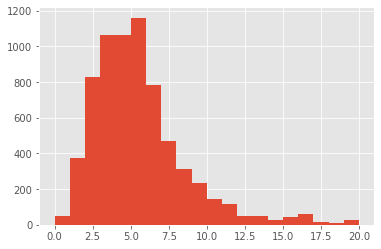

nday_gate_to_plant:


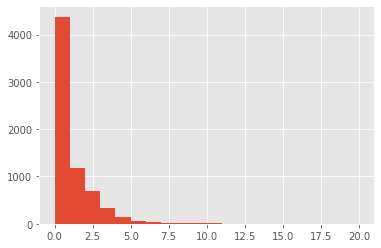

nday_arrival_to_empty:


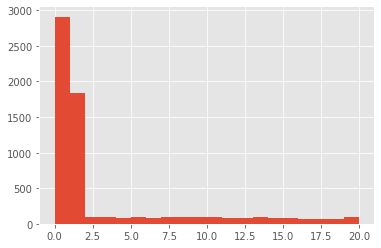

nday_empty_to_exit:


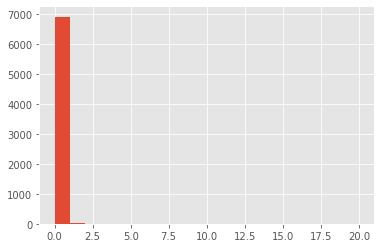

nday_exit_to_return:


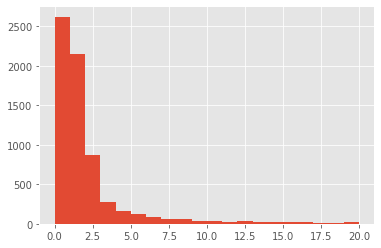

In [490]:
for col in nday_cols:
    print(col + ":")
    hist(import_data.loc[(pd.isna(import_data[col]) == False), col], range=(0, 20), bins=20)

In [491]:
import_data.loc[(nna_filter == True) & (ordered_filter == False), date_cols]

,ata,gateout_date,delivery_arrival_date,unload_finish_date,exit_date,returned_date
1065,2019-01-18,2019-01-21,2019-02-22,2019-02-03,2019-02-03,2019-02-26
1230,2019-01-19,2019-01-25,2019-02-28,2019-01-29,2019-01-29,2019-02-07
1299,2019-01-02,2019-02-01,2019-02-04,2019-02-03,2019-02-03,2019-03-02
1300,2019-01-02,2019-02-01,2019-02-04,2019-02-03,2019-02-03,2019-03-10
1301,2019-01-16,2019-01-29,2019-01-30,2019-01-03,2019-01-03,2019-02-04
...,...,...,...,...,...,...
14381,2019-11-02,2019-11-08,2019-11-08,2019-10-09,2019-10-09,2019-11-10
14382,2019-11-02,2019-11-08,2019-11-08,2019-10-09,2019-10-09,2019-11-10
14411,2019-10-30,2019-11-11,2019-11-11,2019-11-09,2019-11-09,2019-11-09
14549,2019-11-18,2019-11-24,2019-11-23,2019-11-24,2019-11-24,2019-11-24


In [492]:
# exit_date -> unload_finish_date
fix_filter = pd.isna(import_data.unload_finish_date) & (pd.isna(import_data.exit_date) == False)
print("{} null unload_finish_date are fixed by assuming unload_finish_date = exit_date".format(np.sum(fix_filter)))
import_data.loc[fix_filter, "unload_finish_date"] = import_data.loc[fix_filter, "exit_date"].values
import_data.loc[fix_filter, "nday_empty_to_exit"] = 0

3973 null unload_finish_date are fixed by assuming unload_finish_date = exit_date


In [493]:
# unload_finish_date -> exit_date
fix_filter = pd.isna(import_data.exit_date) & (pd.isna(import_data.unload_finish_date) == False)
print("{} null exit_date are fixed by assuming unload_finish_date = exit_date".format(np.sum(fix_filter)))
import_data.loc[fix_filter, "exit_date"] = import_data.loc[fix_filter, "unload_finish_date"].values
import_data.loc[fix_filter, "nday_empty_to_exit"] = 0

0 null exit_date are fixed by assuming unload_finish_date = exit_date


In [494]:
# ata -> gateout_date
freq_dist = summary(import_data.nday_vessel_to_gate.loc[import_data.nday_vessel_to_gate < 15], is_numeric=False)[:-1]
freq_dist["prob"] = freq_dist["Count"] / np.sum(freq_dist["Count"])

fix_filter = pd.isna(import_data.gateout_date) & (pd.isna(import_data.ata) == False)
print("{} null gateout_date are fixed using prob distribution of nday_vessel_to_gate".format(np.sum(fix_filter)))
nday_diff = np.random.choice(freq_dist.index.values.astype("float").astype("int"), np.sum(fix_filter), p=freq_dist["prob"].values)
import_data.loc[fix_filter, "gateout_date"] = import_data.loc[fix_filter, "ata"].values + onedaydelta*nday_diff

secfix_filter = fix_filter & (import_data.gateout_date > import_data.delivery_arrival_date)
print("rectify {} fixed gateout_date to avoid wrong chro order".format(np.sum(secfix_filter)))
import_data.loc[secfix_filter, "gateout_date"] = import_data.loc[secfix_filter, "delivery_arrival_date"].values

188 null gateout_date are fixed using prob distribution of nday_vessel_to_gate
rectify 0 fixed gateout_date to avoid wrong chro order


In [495]:
# gateout_date -> delivery_arrival_date
freq_dist = summary(import_data.nday_gate_to_plant.loc[import_data.nday_gate_to_plant < 5], is_numeric=False)[:-1]
freq_dist["prob"] = freq_dist["Count"] / np.sum(freq_dist["Count"])

fix_filter = pd.isna(import_data.delivery_arrival_date) & (pd.isna(import_data.gateout_date) == False)
print("{} null delivery_arrival_date are fixed using prob distribution of nday_gate_to_plant".format(np.sum(fix_filter)))
nday_diff = np.random.choice(freq_dist.index.values.astype("float").astype("int"), np.sum(fix_filter), p=freq_dist["prob"].values)
import_data.loc[fix_filter, "delivery_arrival_date"] = import_data.loc[fix_filter, "gateout_date"].values + onedaydelta*nday_diff

secfix_filter = fix_filter & (import_data.delivery_arrival_date > import_data.unload_finish_date)
print("rectify {} fixed delivery_arrival_date to avoid wrong chro order".format(np.sum(secfix_filter)))
import_data.loc[secfix_filter, "delivery_arrival_date"] = import_data.loc[secfix_filter, "unload_finish_date"].values

247 null delivery_arrival_date are fixed using prob distribution of nday_gate_to_plant
rectify 0 fixed delivery_arrival_date to avoid wrong chro order


In [496]:
# delivery_arrival_date -> unload_finish_date & exit_date
freq_dist = summary(import_data.nday_arrival_to_empty.loc[import_data.nday_arrival_to_empty < 3], is_numeric=False)[:-1]
freq_dist["prob"] = freq_dist["Count"] / np.sum(freq_dist["Count"])

fix_filter = pd.isna(import_data.unload_finish_date) & (pd.isna(import_data.delivery_arrival_date) == False)
print("{} null unload_finish_date are fixed using prob distribution of nday_arrival_to_empty".format(np.sum(fix_filter)))
nday_diff = np.random.choice(freq_dist.index.values.astype("float").astype("int"), np.sum(fix_filter), p=freq_dist["prob"].values)
import_data.loc[fix_filter, "unload_finish_date"] = import_data.loc[fix_filter, "delivery_arrival_date"].values + onedaydelta*nday_diff

secfix_filter = fix_filter & (import_data.unload_finish_date > import_data.returned_date)
print("rectify {} fixed unload_finish_date to avoid wrong chro order".format(np.sum(secfix_filter)))
import_data.loc[secfix_filter, "unload_finish_date"] = import_data.loc[secfix_filter, "returned_date"].values

fix_filter = fix_filter & pd.isna(import_data.exit_date)
print("{} null exit_date are fixed".format(np.sum(fix_filter)))
import_data.loc[fix_filter, "exit_date"] = import_data.loc[fix_filter, "unload_finish_date"].values

3277 null unload_finish_date are fixed using prob distribution of nday_arrival_to_empty
rectify 0 fixed unload_finish_date to avoid wrong chro order
3277 null exit_date are fixed


In [497]:
# exit_date -> returned_date
freq_dist = summary(import_data.nday_exit_to_return.loc[import_data.nday_exit_to_return < 20], is_numeric=False)[:-1]
freq_dist["prob"] = freq_dist["Count"] / np.sum(freq_dist["Count"])

fix_filter = pd.isna(import_data.returned_date) & (pd.isna(import_data.exit_date) == False)
print("{} null returned_date are fixed using prob distribution of nday_exit_to_return".format(np.sum(fix_filter)))
nday_diff = np.random.choice(freq_dist.index.values.astype("float").astype("int"), np.sum(fix_filter), p=freq_dist["prob"].values)
import_data.loc[fix_filter, "returned_date"] = import_data.loc[fix_filter, "exit_date"].values + onedaydelta*nday_diff

3449 null returned_date are fixed using prob distribution of nday_exit_to_return


In [498]:
np.sum(pd.isna(import_data[date_cols]))

ata                      0
gateout_date             0
delivery_arrival_date    0
unload_finish_date       0
exit_date                0
returned_date            0
dtype: int64

In [499]:
calc_ndays()

14284 records have non-empty dates
14109 records have non-empty and correctly ordered dates


nday_vessel_to_gate:


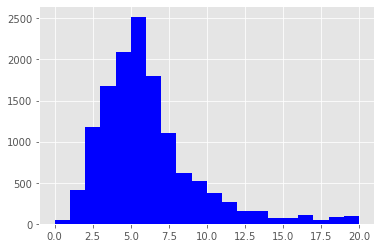

nday_gate_to_plant:


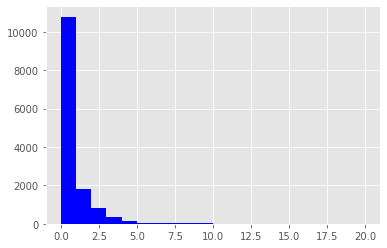

nday_arrival_to_empty:


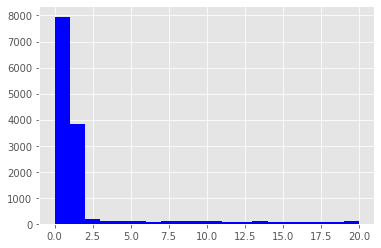

nday_empty_to_exit:


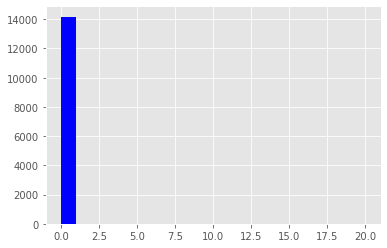

nday_exit_to_return:


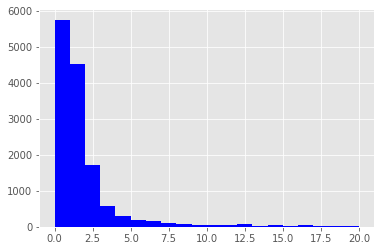

In [500]:
for col in nday_cols:
    print(col + ":")
    hist(import_data.loc[(pd.isna(import_data[col]) == False), col], range=(0, 20), bins=20, color="blue")


In [501]:
import_data.loc[634, "gateout_date"] = np.datetime64("2019-01-18")
import_data.loc[687, "gateout_date"] = np.datetime64("2019-01-29")
import_data.loc[709, "delivery_arrival_date"] = np.datetime64("2019-01-25")
import_data.loc[769, "delivery_arrival_date"] = np.datetime64("2019-01-27")
import_data.loc[923, "delivery_arrival_date"] = np.datetime64("2019-02-02")
ordered_filter = (import_data.ata <= import_data.gateout_date) & (import_data.gateout_date <= import_data.delivery_arrival_date) & (import_data.delivery_arrival_date <= import_data.unload_finish_date) & (import_data.unload_finish_date <= import_data.exit_date) & (import_data.exit_date <= import_data.returned_date)
import_data = import_data.loc[ordered_filter, :]


In [502]:
calc_ndays()

14114 records have non-empty dates
14114 records have non-empty and correctly ordered dates


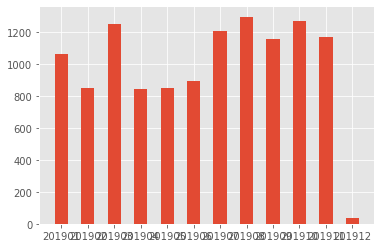

In [503]:
grp_by_month = import_data[["po_1", "month_sn"]].groupby(["month_sn"]).count()
barplot(grp_by_month)

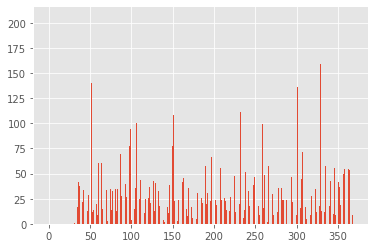

In [504]:
grp_by_day = import_data[["po_1", "day_sn"]].groupby(["day_sn"]).count()
barplot(grp_by_day)

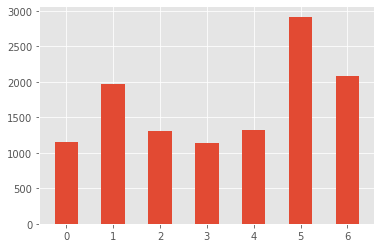

In [505]:
grp_by_wday = import_data[["po_1", "wday"]].groupby(["wday"]).count()
barplot(grp_by_wday)

In [274]:
for col in nday_cols:
    dirty_filter = pd.isna(import_data[col]) | (import_data[col] < 0)
    import_data.loc[dirty_filter, col] = np.median(import_data.loc[dirty_filter == False, col].values)

In [278]:
import_data = import_data.loc[import_data.nday_vessel_to_gate < 30, :]
import_data = import_data.loc[import_data.nday_gate_to_plant < 4, :]
import_data = import_data.loc[import_data.nday_arrival_to_empty < 20, :]
import_data = import_data.loc[import_data.nday_empty_to_exit < 2, :]
import_data = import_data.loc[import_data.nday_exit_to_return < 8, :]

In [264]:
# for col in nday_cols:
#     q3 = max(np.quantile(import_data[col], 0.75), 1)
#     q1 = np.quantile(import_data[col], 0.25)
#     iqr = q3 - q1
#     outlier_filter = import_data[col] > (q3 + iqr*20)
#     print(np.sum(outlier_filter))
#     import_data = import_data.loc[outlier_filter == False, :]